<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Capture-Picture-for-geometric-path-presentation" data-toc-modified-id="Capture-Picture-for-geometric-path-presentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Capture Picture for geometric path presentation</a></span></li><li><span><a href="#Simulate-nominal-motion" data-toc-modified-id="Simulate-nominal-motion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate nominal motion</a></span></li><li><span><a href="#Simulate-all-three-controller" data-toc-modified-id="Simulate-all-three-controller-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulate all three controller</a></span><ul class="toc-item"><li><span><a href="#Preview-TT-controller" data-toc-modified-id="Preview-TT-controller-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preview TT controller</a></span></li><li><span><a href="#Error-trajectory" data-toc-modified-id="Error-trajectory-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Error trajectory</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append('../')
import following_lib as fo

In [2]:
import numpy as np
import openravepy as orpy
import toppra as ta
import matplotlib.pyplot as plt
from rave.Rave import inv_dyn
import time

# Setup Logging
import logging
import coloredlogs
logger = logging.getLogger('trajectory')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('traj.log', mode='a')
logger.addHandler(fh)

# Setup logging for toppra
coloredlogs.install(level='DEBUG')
np.set_printoptions(5)

# Load OpenRAVE environment
env = orpy.Environment()
env.SetViewer('qtosg')

True

# Capture Picture for geometric path presentation

This script generate and setup the robot to demonstrate a geometric path.

In [3]:
env.Reset()
# Load N robots
N = 3
for i in range(N):
    env.Load('/home/hung/git/robotic-CRI/rave/plannar_3DOF_arm.robot.xml')
    env.GetRobots()[i].SetName('robot{:d}'.format(i))

# Geometric path
waypoints = np.array([[0., 0.5, 0.5],
                      [-1.5, -1.0, -0.5],
                      [- 1., - 0.8, - 1.3],
                      [1., 0.4, -1.4]])
path = ta.SplineInterpolator(np.linspace(0, 1, 4), waypoints)

In [4]:
ss = [0, 0.35, 0.7]
q = path.eval(ss)
for i, q_ in enumerate(q):
    env.GetRobots()[i].SetDOFValues(q_)

for l in env.GetRobots()[1].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0.2)
        

for l in env.GetRobots()[2].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0.3)

In [5]:
viewer = env.GetViewer()
viewer.SetCamera(np.array([[-0.6423 ,  0.23435, -0.72975,  1.76622],
       [ 0.7662 ,  0.22085, -0.60346,  1.46306],
       [ 0.01975, -0.94674, -0.32141,  1.24293],
       [ 0.     ,  0.     ,  0.     ,  1.     ]]))

# Simulate nominal motion

In [6]:
env.Reset()
env.Load('/home/hung/git/robotic-CRI/rave/plannar_3DOF_arm.robot.xml')
robot = env.GetRobots()[0]

tau_max = np.r_[50., 50., 50.] * 2
robot.SetDOFTorqueLimits(tau_max)
robot.SetDOFVelocityLimits(tau_max)
tau_min = - tau_max

# TOPP
N = 100
ss = np.linspace(0, 1, N+1)
cnst = ta.create_rave_torque_path_constraint(path, np.linspace(0, 1, N+1), robot)
cnst_intp = ta.interpolate_constraint(cnst)
pp = ta.qpOASESPPSolver([cnst_intp])
pp.set_goal_interval([0, 1e-8])
pp.set_start_interval([0, 1e-5])
pp.solve_controllable_sets()
us, xs = pp.solve_topp()

ts, qs, qds, qdds, ss_ref = fo.compute_trajectory_points(
    path, pp.ss, us, xs, dt=1e-3, smooth=False)



2018-02-28 22:36:28 hung-asus toppra.constraints[4998] INFO Torque bounds for OpenRAVE robot generated.
2018-02-28 22:36:28 hung-asus toppra.TOPP[4998] INFO 
Initialize Path Parameterization instance
------------------------------
	 N                  :      100
	 No. of constraints :        1
	 No. of slack var   :        0
	 No. of can. ineq.  :       12
	 No. of equalities  :        0
	 No. of inequalities:        0

2018-02-28 22:36:28 hung-asus toppra.TOPP[4998] DEBUG Set qpOASES print level to NONE


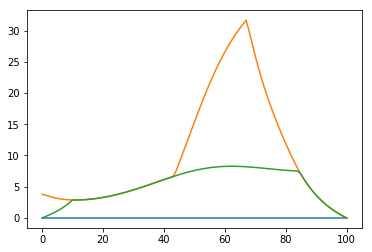

In [7]:
plt.plot(pp.K)
plt.plot(xs)
plt.show()

In [8]:
slowdown = 2
for q_ in qs:
    robot.SetDOFValues(q_)
    time.sleep(1e-3 * slowdown)

# Simulate all three controller

OSG is actually the TOPT controller

In [9]:
# Tracking parameter
lamb = 30
dof = robot.GetDOF()

###############################################################################
#                   OSG_tb : Online Scaling w/Robust guarantee               #
###############################################################################

# Robust controllable sets the OSG controller
# TODO: Compute Ps propoerly.
vs = np.zeros((N+1, dof * 2, 3))
Ps = np.zeros((N+1, dof * 2, 3, 3))
vs[:, :, 0] = cnst.a
vs[:, :, 1] = cnst.b
vs[:, :, 2] = cnst.c

Ps[:, :] = np.eye(3) * 50



robust_cnst = fo.RobustPathConstraint(vs, Ps, ss)
ws = 0.05 * np.ones(N+1)  # Norm of the tracking error
Ks = np.ones((N+1, 2))  # Robust controllable sets
Ks[N] = [0, 1e-8]
for i in range(N-1, -1, -1):
    Ks[i] = fo.robust_one_step(robust_cnst, i, Ks[i + 1], ws[i], ws[i + 1], method='ECOS')
    logger.info("OSRG: K{:d} = {:}".format(i, Ks[i]))

2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K99 = [ -2.16138e-09   1.81325e-01]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K98 = [  1.07665e-11   3.72764e-01]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K97 = [  1.37670e-10   5.75496e-01]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K96 = [  1.29301e-10   7.90701e-01]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K95 = [  4.21604e-11   1.01956e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K94 = [  1.23950e-10   1.26325e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K93 = [  1.16727e-10   1.52294e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K92 = [  1.18278e-10   1.79984e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K91 = [  1.34109e-10   2.09511e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K90 = [  1.37688e-10   2.40995e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K8

2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K11 = [  1.90195e-12   2.49233e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K10 = [  1.32884e-10   2.50813e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K9 = [  2.15369e-11   2.53340e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K8 = [  5.02368e-11   2.56887e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K7 = [  7.23415e-11   2.61546e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K6 = [  8.76506e-11   2.67428e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K5 = [  9.57574e-11   2.74666e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K4 = [  1.04420e-10   2.83421e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K3 = [  1.14679e-10   2.93881e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K2 = [  1.23005e-10   3.06275e+00]
2018-02-28 22:36:30 hung-asus trajectory[4998] INFO OSRG: K1 = [  1.

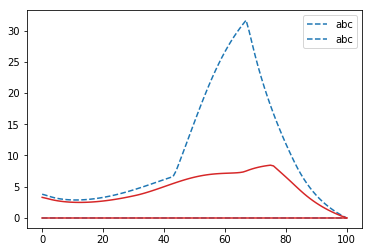

In [10]:
plt.plot(pp.K, '--', c='C0', label='abc')
plt.plot(Ks, c='C3')
# plt.plot(xs)
plt.legend()
plt.show()

In [11]:
# Define experiments
reload(fo)
OSG_exp = fo.ExperimentOSG(robot, path, Ks, ss,
                           tau_min, tau_max, lamb)
OS_exp = fo.ExperimentOS(robot, path, us, xs, ss,
                         tau_min, tau_max, lamb)
TT_exp = fo.ExperimentTT(robot, path, qs, qds, qdds,
                         tau_min, tau_max, lamb)
TT_notrb_exp = fo.ExperimentTT(robot, path, qs, qds, qdds,
                               10 * tau_min, 10 * tau_max, lamb)
experiments = [OSG_exp, OS_exp, TT_exp]

# Setup
initial_err = np.array([0.02483, 0.05122,  0.02318,
                        0.      ,  0.     ,  0.     ])
initial_err = 0.2 * initial_err / np.linalg.norm(initial_err)


for exp in experiments:
    exp.set_unit_noise_function(lambda t: 0)
    # exp.set_noise_level(10.)
    exp.set_noise_level(0.)
    exp.set_initial_error(initial_err)
    exp.lamb = lamb
    exp.reset()


In [12]:
TT_res = TT_exp.run()
OSG_res = OSG_exp.run()

2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Starting simulation
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 0.000000%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 0.168634%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 0.337268%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 0.505902%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 0.674536%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 0.843170%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 1.011804%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 1.180438%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 1.349073%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulation progress 1.517707%
2018-02-28 22:36:30 hung-asus following_lib[4998] DEBUG Simulati

2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 15.851602%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 16.020236%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 16.188870%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 16.357504%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 16.526138%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 16.694772%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 16.863406%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 17.032040%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 17.200675%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 17.369309%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 17.537943%
2018-02-28 22:36:31 hung-asus following_lib

2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 31.871838%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 32.040472%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 32.209106%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 32.377740%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 32.546374%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 32.715008%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 32.883642%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 33.052277%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 33.220911%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 33.389545%
2018-02-28 22:36:31 hung-asus following_lib[4998] DEBUG Simulation progress 33.558179%
2018-02-28 22:36:31 hung-asus following_lib

2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 47.892074%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 48.060708%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 48.229342%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 48.397976%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 48.566610%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 48.735245%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 48.903879%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 49.072513%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 49.241147%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 49.409781%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 49.578415%
2018-02-28 22:36:32 hung-asus following_lib

2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 63.912310%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 64.080944%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 64.249578%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 64.418212%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 64.586847%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 64.755481%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 64.924115%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 65.092749%
2018-02-28 22:36:32 hung-asus following_lib[4998] DEBUG Simulation progress 65.261383%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 65.430017%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 65.598651%
2018-02-28 22:36:33 hung-asus following_lib

2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 79.932546%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 80.101180%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 80.269815%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 80.438449%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 80.607083%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 80.775717%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 80.944351%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 81.112985%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 81.281619%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 81.450253%
2018-02-28 22:36:33 hung-asus following_lib[4998] DEBUG Simulation progress 81.618887%
2018-02-28 22:36:33 hung-asus following_lib

2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 95.952782%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 96.121417%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 96.290051%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 96.458685%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 96.627319%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 96.795953%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 96.964587%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 97.133221%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 97.301855%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 97.470489%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 97.639123%
2018-02-28 22:36:34 hung-asus following_lib

2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 1.654422%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 1.715714%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 1.778216%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 1.841931%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 1.906863%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 1.973014%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 2.040390%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 2.108994%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 2.178830%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 2.249902%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBUG Simulation progress 2.322214%
2018-02-28 22:36:34 hung-asus following_lib[4998] DEBU

2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 13.301028%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 13.458867%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 13.616775%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 13.774752%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 13.932798%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 14.090913%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 14.249111%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 14.407407%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 14.565801%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 14.724292%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 14.882881%
2018-02-28 22:36:35 hung-asus following_lib

2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 29.282078%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 29.468274%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 29.654983%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 29.842205%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 30.029941%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 30.218210%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 30.407033%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 30.596410%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 30.786340%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 30.976824%
2018-02-28 22:36:35 hung-asus following_lib[4998] DEBUG Simulation progress 31.167862%
2018-02-28 22:36:35 hung-asus following_lib

2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 50.155358%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 50.411192%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 50.667566%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 50.924479%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 51.181932%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 51.439896%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 51.698344%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 51.957275%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 52.216689%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 52.476558%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 52.736853%
2018-02-28 22:36:36 hung-asus following_lib

2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 75.598038%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 75.869872%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 76.141603%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 76.413229%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 76.684747%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 76.956158%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 77.227461%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 77.498233%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 77.768051%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 78.036916%
2018-02-28 22:36:36 hung-asus following_lib[4998] DEBUG Simulation progress 78.304509%
2018-02-28 22:36:36 hung-asus following_lib

2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 93.925599%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.038888%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.150919%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.261731%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.371324%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.479698%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.586854%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.692790%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.797507%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 94.901006%
2018-02-28 22:36:37 hung-asus following_lib[4998] DEBUG Simulation progress 95.003286%
2018-02-28 22:36:37 hung-asus following_lib

2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 99.871372%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 99.886618%


In [13]:
OS_res = OS_exp.run()

2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Starting simulation
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.000000%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.000506%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.001389%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.002052%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.002572%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.003021%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.003471%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.003986%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.004630%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 0.005462%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulati

2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.272775%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.356372%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.441149%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.527104%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.614239%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.702552%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.792044%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.882716%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 3.974566%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 4.067594%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBUG Simulation progress 4.161853%
2018-02-28 22:36:38 hung-asus following_lib[4998] DEBU

2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 16.826613%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 17.004403%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 17.182571%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 17.361126%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 17.540077%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 17.719434%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 17.899206%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 18.079404%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 18.260036%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 18.441113%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 18.622644%
2018-02-28 22:36:39 hung-asus following_lib

2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 37.605451%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 37.951644%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 38.311667%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 38.688353%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 39.085572%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 39.508830%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 39.966370%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 40.471436%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 41.047588%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 41.651315%
2018-02-28 22:36:39 hung-asus following_lib[4998] DEBUG Simulation progress 42.225739%
2018-02-28 22:36:39 hung-asus following_lib

2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 60.176333%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 60.425376%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 60.675081%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 60.925436%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 61.176434%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 61.428062%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 61.680312%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 61.933172%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 62.186634%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 62.440685%
2018-02-28 22:36:40 hung-asus following_lib[4998] DEBUG Simulation progress 62.695316%
2018-02-28 22:36:40 hung-asus following_lib

2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 85.354104%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 85.609954%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 85.861927%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 86.110070%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 86.354540%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 86.595449%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 86.832803%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 87.066649%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 87.297122%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 87.524321%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 87.748250%
2018-02-28 22:36:41 hung-asus following_lib

2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.664939%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.722809%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.779329%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.834498%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.888317%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.940787%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 98.991913%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 99.041698%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 99.090184%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 99.137411%
2018-02-28 22:36:41 hung-asus following_lib[4998] DEBUG Simulation progress 99.183377%
2018-02-28 22:36:41 hung-asus following_lib

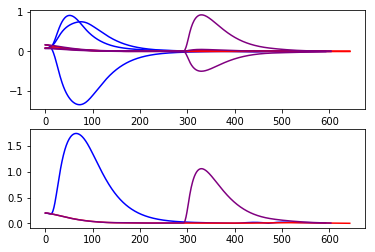

In [14]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(TT_res['traj_e'][:, :3], c='blue')
axs[0].plot(OSG_res['traj_e'][:, :3], c='red')
axs[0].plot(OS_res['traj_e'][:, :3], c='purple')
axs[1].plot(np.linalg.norm(TT_res['traj_e'][:, :3], axis=1), c='blue')
axs[1].plot(np.linalg.norm(OSG_res['traj_e'][:, :3], axis=1), c='red')
axs[1].plot(np.linalg.norm(OS_res['traj_e'][:, :3], axis=1), c='purple')
plt.show()

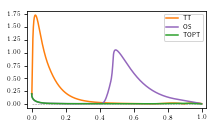

In [16]:
###############################################################################
#                    Compare norm of tracking error                    #
###############################################################################
# PLotting
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['text.usetex'] = True
f, ax = plt.subplots(figsize=[3.2, 1.8])
ax.plot(ss_ref,
        np.linalg.norm(TT_res['traj_e'][:, :3], axis=1), '-',
        label='TT', c='C1')
ax.plot(OS_res['traj_s'],
        np.linalg.norm(OS_res['traj_e'][:, :3], axis=1), '-',
        label='OS', c='C4')
ax.plot(OSG_res['traj_s'],
        np.linalg.norm(OSG_res['traj_e'][:, :3], axis=1),
        label='TOPT', c='C2')
ax.plot((0, 1), (0, 0), '--', lw=0.5, c='gray')
# ax.set_ylim(-0.0015, 0.02)
ax.set_xlim(-0.025, 1.025)
# ax.set_yticks(np.arange(0, 0.021, 0.002))
ax.legend()
plt.savefig('/home/hung/git/hung/Papers/2017-TOPP-following/figures/3axis_compare_tracking_performance.pdf')
plt.show()

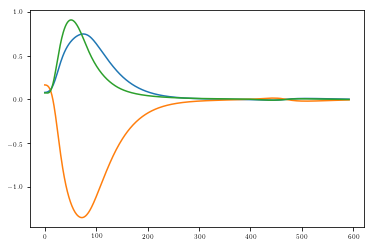

In [16]:
plt.plot(TT_res['traj_e'][:, :3])
plt.show()

In [17]:
robot.SetName('old_robot')
env.Load('/home/hung/git/robotic-CRI/rave/plannar_3DOF_arm.robot.xml')
robot2 = env.GetRobots()[1]

In [35]:
# Make robot 2, which will runs the parameterization, shifted a little behind
I = np.eye(4)
I[:3, 3] = [-0.008, -0.008, - 0.005]
robot2.SetTransform(I)

In [19]:
for l in env.GetRobots()[1].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0.1)
        geom.SetDiffuseColor([0.9, 0.3, 0.3])

for l in env.GetRobots()[0].GetLinks():
    for geom in l.GetGeometries():
        geom.SetTransparency(0)
        geom.SetDiffuseColor([0.9, 0.9, 0.9])

## Preview TT controller

In [25]:
viewer = env.GetViewer()
viewer.GetCameraTransform()
viewer.SetCamera(np.array([[-0.8471 ,  0.24035, -0.47398,  0.57481],
       [ 0.53143,  0.37929, -0.75744,  0.71682],
       [-0.00228, -0.89351, -0.44903,  0.61461],
       [ 0.     ,  0.     ,  0.     ,  1.     ]]))

In [40]:
slowdown = 8
robot.SetDOFValues(TT_res['traj_q'][0])
robot2.SetDOFValues(qs[0])
time.sleep(5)
for q_, q_2 in zip(TT_res['traj_q'], qs):
    robot.SetDOFValues(q_)
    robot2.SetDOFValues(q_2)
    time.sleep(1e-3 * slowdown)
time.sleep(1)

In [41]:
slowdown = 8
qs_OS = path.eval(OS_res['traj_s'])
robot.SetDOFValues(OS_res['traj_q'][0])
robot2.SetDOFValues(qs_OS[0])
time.sleep(5)
for q_, q_2 in zip(OS_res['traj_q'], qs_OS):
    robot.SetDOFValues(q_)
    robot2.SetDOFValues(q_2)
    time.sleep(1e-3 * slowdown)
time.sleep(1)

In [42]:
slowdown = 8
qs_OSG = path.eval(OSG_res['traj_s'])
robot.SetDOFValues(OSG_res['traj_q'][0])
robot2.SetDOFValues(qs_OSG[0])
time.sleep(5)
for q_, q_2 in zip(OSG_res['traj_q'], qs_OSG):
    robot.SetDOFValues(q_)
    robot2.SetDOFValues(q_2)
    time.sleep(1e-3 * slowdown)
time.sleep(1)

In [39]:
print TT_res['traj_t'][-1], OS_res['traj_t'][-1], OSG_res['traj_t'][-1]

0.593 0.604 0.644


In [43]:
robot.SetDOFValues(TT_res['traj_q'][0])
robot2.SetDOFValues(qs[0])

## Error trajectory

In [59]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

# Fixing random state for reproducibility
np.random.seed(19680801)


# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)


fig1 = plt.figure()

data = np.random.rand(2, 25)
l1, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('/home/hung/Videos/lines.mp4', writer=writer)

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
im_ani.save('/home/hung/Videos/im.mp4', writer=writer)